# Machine Learning 2 - Semester Project 
# Garbage Classification

<div class="alert alert-block alert-info">
<b>Tip:</b> Revised Order:

1. **Data Collection:**
   - Collect a dataset of images representing different types of garbage items (plastic, paper, glass, etc.).
   - Found multiple data sets on kaggle
    
2. **Image Classification:**
   - Use convolutional neural networks (CNNs) to build an image classification model.
   - Train the model to recognize and classify each type of garbage item.
   - Evaluate the model's performance using appropriate metrics.

3. **Pre-trained Models Comparison:**
   - Choose popular pre-trained models for image classification (e.g., ResNet, VGG, MobileNet).
   - Fine-tune these models on your garbage classification dataset.
   - Evaluate the performance of the fine-tuned models.
   - Compare the performance metrics with your custom-trained model.

4. **Clustering and Dimension Reduction:**
   - Apply clustering algorithms (e.g., K-Means) to group similar garbage items together.
        - (Hope to find clusters like: recycleable/ bio/ others
   - Use dimension reduction techniques (e.g., PCA) to visualize and analyze the features of the garbage items.

5. **Integrating Recommendations:**
   - Implement a recommendation system that suggests the appropriate recycling bin for a given item.
        - maybe simple tree?? 
   - Use knowledge from the clustering and dimension reduction to enhance recommendation accuracy.


</div>


### Import Libraries

In [1]:
# Standard Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for Images 
import os
import glob
from PIL import Image


# Libraries for Evaluations and Train/Test Split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from kerastuner.tuners import BayesianOptimization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

#Evaluation
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel

#Model Visualization
from ann_visualizer.visualize import ann_viz
from tensorflow.keras.utils import plot_model


#Others
from tqdm import tqdm  # Optional: tqdm for progress bar
from concurrent.futures import ThreadPoolExecutor

/var/folders/2b/c643wm_d7xl9868bh1t2r6n80000gn/T/ipykernel_1468/1367899145.py:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


## Download Data for Images 

In [2]:
def count_images_in_folder(folder_path, image_extensions=['jpg', 'jpeg', 'png', 'gif', 'bmp']):
    # Ensure the folder path is valid
    if not os.path.exists(folder_path):
        print(f"Error: The folder '{folder_path}' does not exist.")
        return None

    # Use glob to get a list of files matching the specified extensions
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(folder_path, f'*.{ext}')))

    # Count the number of images
    num_images = len(image_files)

    return num_images

folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification/battery'
num_images = count_images_in_folder(folder_path)

if num_images is not None:
    print(f'The folder "{folder_path}" contains {num_images} images.')


The folder "/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification/battery" contains 945 images.


In [3]:
def count_images_in_subfolders(root_folder, image_extensions=['jpg', 'jpeg', 'png', 'gif', 'bmp']):
    # Ensure the root folder path is valid
    if not os.path.exists(root_folder):
        print(f"Error: The folder '{root_folder}' does not exist.")
        return None
    # Initialize an empty list to store results
    data = []

    # Iterate through subfolders
    for subfolder_name in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder_name)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Use glob to count images in the subfolder
            image_files = []
            for ext in image_extensions:
                image_files.extend(glob.glob(os.path.join(subfolder_path, f'*.{ext}')))

            # Count the number of images
            num_images = len(image_files)

            # Append the results to the list
            data.append({'Classes': subfolder_name, 'Number_Images': num_images})

    # Convert the list to a DataFrame
    df = pd.DataFrame(data)

    return df

In [4]:
# Example usage:
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification/'
image_overview = count_images_in_subfolders(root_folder_path)

image_overview

,Classes,Number_Images
0,paper,1050
1,green-glass,629
2,clothes,5325
3,metal,769
4,cardboard,891
5,trash,697
6,biological,985
7,white-glass,775
8,battery,945
9,brown-glass,607


In [5]:
image_overview['Number_Images'].sum()

15515

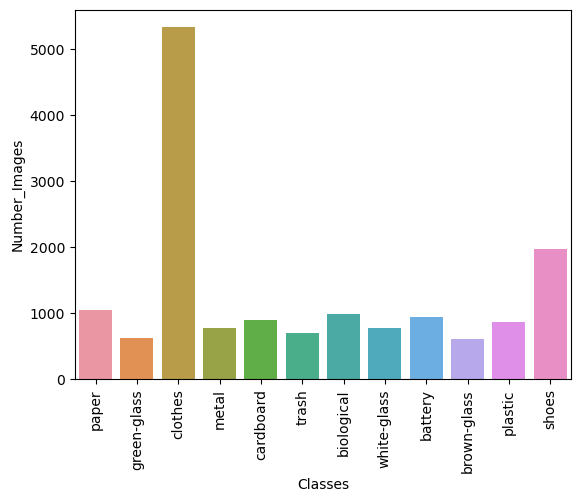

In [6]:
sns.barplot(image_overview, x="Classes", y="Number_Images")
plt.xticks(rotation=90)
plt.show()

## Different Models for Importing the Images

### Storing in a df 
- very time consuming

In [7]:
def load_images_into_dataframe(root_folder, image_extensions=['jpg', 'jpeg', 'png', 'gif', 'bmp'], batch_size=100):
    # Ensure the root folder path is valid
    if not os.path.exists(root_folder):
        print(f"Error: The folder '{root_folder}' does not exist.")
        return None

    data = {'Image': [], 'Label': []}

    # Function to load images in parallel
    def process_images(args):
        image_file, label = args
        try:
            # Load image using PIL
            img = Image.open(image_file)

            # Convert image to NumPy array
            img_array = np.array(img)

            # Append data to the dictionary
            data['Image'].append(img_array)
            data['Label'].append(label)
        except Exception as e:
            print(f"Error loading image {image_file}: {e}")

    # Iterate through subfolders
    for label in tqdm(os.listdir(root_folder), desc="Processing Subfolders", unit="subfolder"):
        label_path = os.path.join(root_folder, label)

        # Check if it's a directory
        if os.path.isdir(label_path):
            # Use ThreadPoolExecutor for parallel processing
            with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
                image_files = []
                for ext in image_extensions:
                    image_files.extend(glob.glob(os.path.join(label_path, f'*.{ext}')))

                # Process images in batches
                label_image_pairs = [(image_file, label) for image_file in image_files]
                for i in tqdm(range(0, len(label_image_pairs), batch_size), desc="Processing Images", unit="batch"):
                    batch_files = label_image_pairs[i:i + batch_size]
                    executor.map(process_images, batch_files)

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(data)

    return df

# Example usage:
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'
image_df = load_images_into_dataframe(root_folder_path)
image_df.head()


Processing Subfolders: 100%|█████████████| 13/13 [00:07<00:00,  1.66subfolder/s]


,Image,Label
0,"[[[197, 189, 178], [197, 189, 178], [198, 190,...",paper
1,"[[[202, 202, 202], [202, 202, 202], [202, 202,...",paper
2,"[[[255, 254, 252], [255, 255, 253], [255, 255,...",paper
3,"[[[255, 255, 253], [255, 255, 253], [255, 255,...",paper
4,"[[[48, 65, 75], [9, 26, 36], [15, 32, 42], [12...",paper


In [8]:
image_df.info

<bound method DataFrame.info of                                                    Image  Label
0      [[[197, 189, 178], [197, 189, 178], [198, 190,...  paper
1      [[[202, 202, 202], [202, 202, 202], [202, 202,...  paper
2      [[[255, 254, 252], [255, 255, 253], [255, 255,...  paper
3      [[[255, 255, 253], [255, 255, 253], [255, 255,...  paper
4      [[[48, 65, 75], [9, 26, 36], [15, 32, 42], [12...  paper
...                                                  ...    ...
15510  [[[255, 255, 255], [255, 255, 255], [255, 255,...  shoes
15511  [[[255, 255, 255], [255, 255, 255], [255, 255,...  shoes
15512  [[[98, 100, 63], [88, 90, 53], [116, 118, 81],...  shoes
15513  [[[186, 186, 178], [187, 187, 179], [189, 189,...  shoes
15514  [[[183, 209, 226], [183, 209, 226], [183, 209,...  shoes

[15515 rows x 2 columns]>

In [9]:
image_df.head()

,Image,Label
0,"[[[197, 189, 178], [197, 189, 178], [198, 190,...",paper
1,"[[[202, 202, 202], [202, 202, 202], [202, 202,...",paper
2,"[[[255, 254, 252], [255, 255, 253], [255, 255,...",paper
3,"[[[255, 255, 253], [255, 255, 253], [255, 255,...",paper
4,"[[[48, 65, 75], [9, 26, 36], [15, 32, 42], [12...",paper


### Use ImageData Generator 

In [10]:
# Define the root folder where your subfolders (class folders) are located
root_folder_path = '/path/to/your/root/folder'
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'

# Define the ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,       # Rescale pixel values to be between 0 and 1
    shear_range=0.2,      # Shear transformation
    zoom_range=0.2,       # Random zoom
    horizontal_flip=True, # Random horizontal flip
    validation_split=0.2  # Split data into training and validation sets
)

# Define the target image size
target_size = (256,256)  # Adjust according to your model's input size

# Create the training data generator
train_generator = datagen.flow_from_directory(
    root_folder_path,
    target_size=target_size,
    batch_size=32,         # Adjust based on your system's memory
    class_mode='categorical',  # Assumes a classification task
    subset='training'      # Specify 'training' for training data
)

# Create the validation data generator
validation_generator = datagen.flow_from_directory(
    root_folder_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'    # Specify 'validation' for validation data
)


Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.


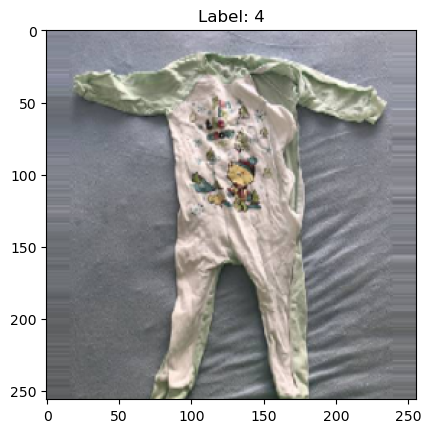

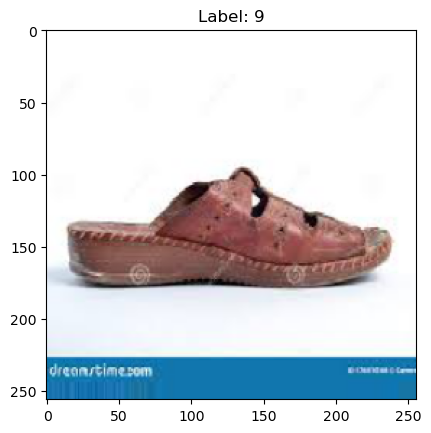

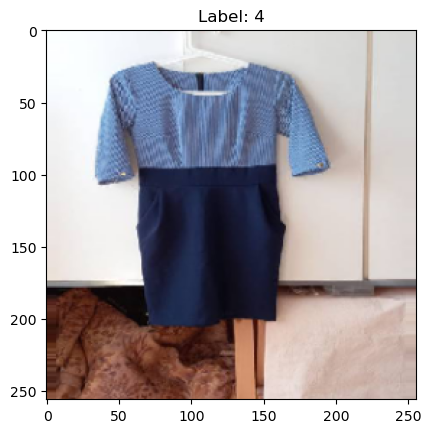

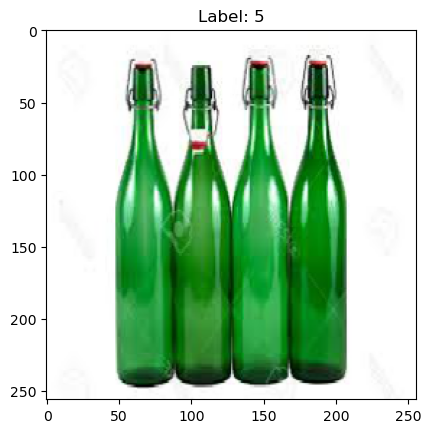

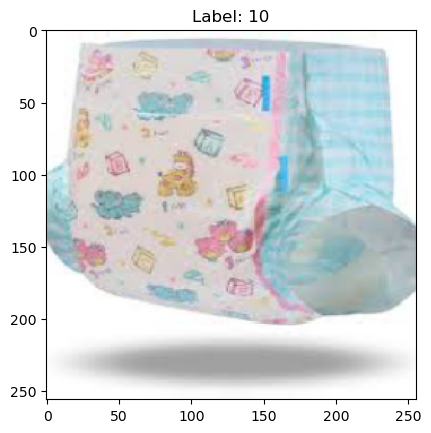

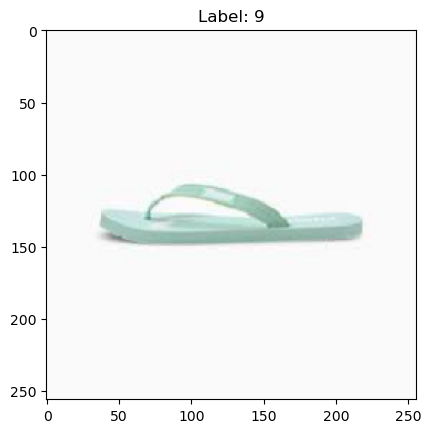

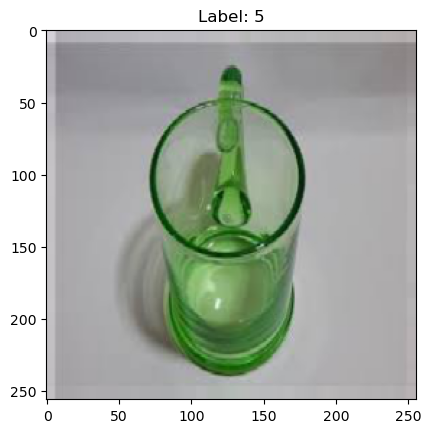

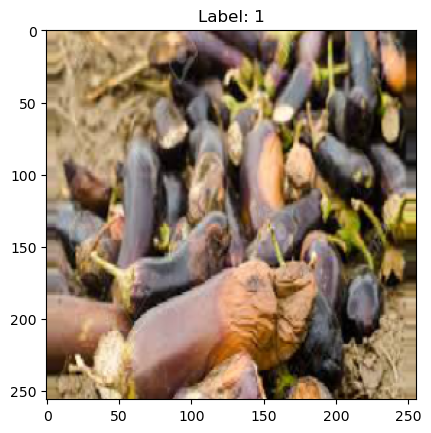

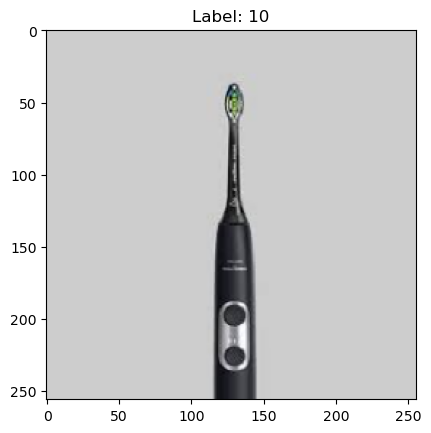

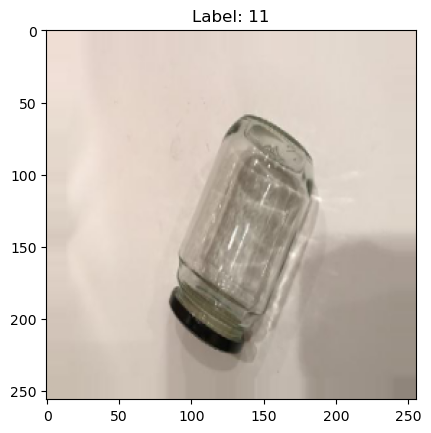

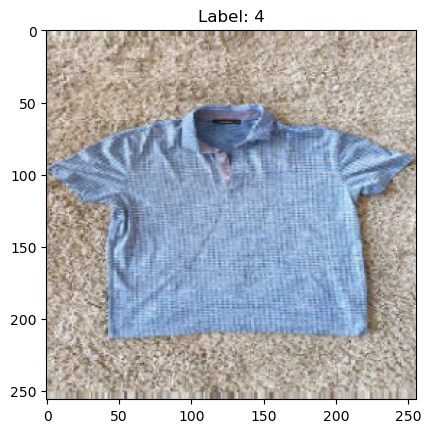

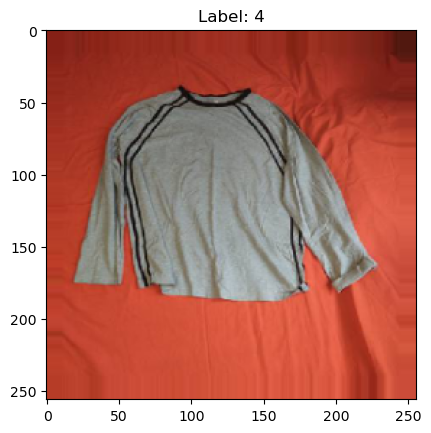

In [11]:
import matplotlib.pyplot as plt

# Get a batch from the training generator
batch_images, batch_labels = next(train_generator)

# Visualize the first few images in the batch
num_images_to_visualize = 12
for i in range(num_images_to_visualize):
    # Get the image and label
    image = batch_images[i]
    label_index = np.argmax(batch_labels[i])
    
    # Plot the image
    plt.imshow(image)
    plt.title(f"Label: {label_index}")
    plt.show()

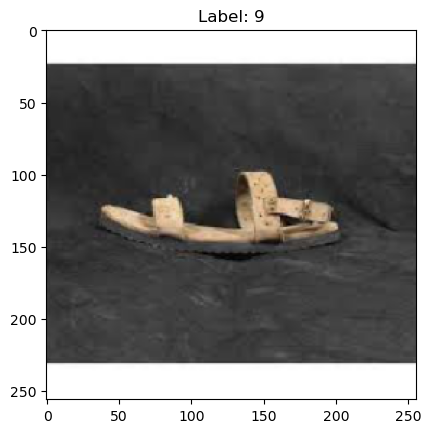

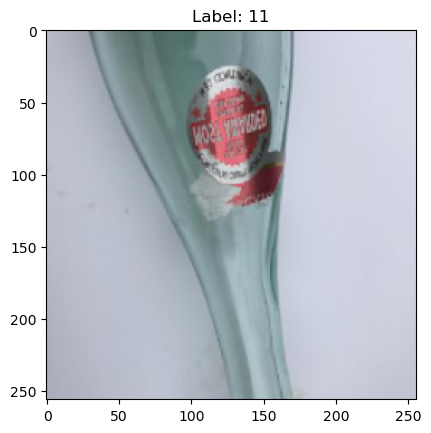

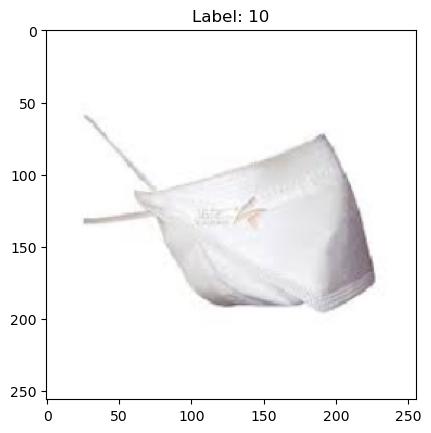

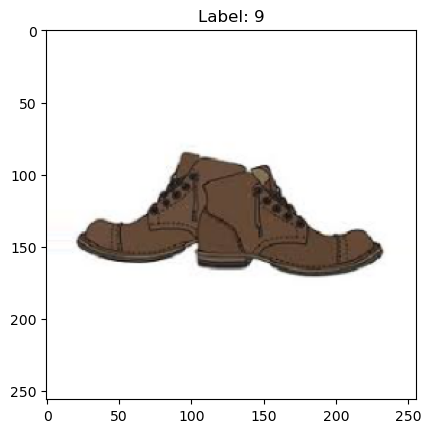

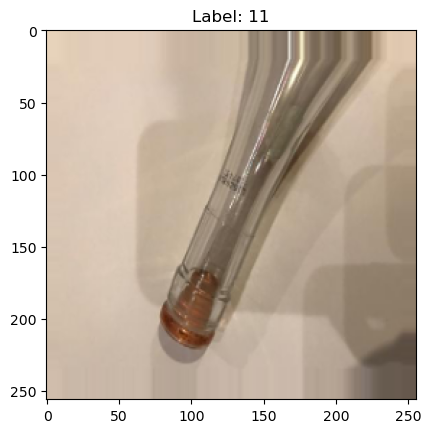

In [12]:
# Get a batch from the training generator
batch_images, batch_labels = next(validation_generator)

# Visualize the first few images in the batch
num_images_to_visualize = 5
for i in range(num_images_to_visualize):
    # Get the image and label
    image = batch_images[i]
    label_index = np.argmax(batch_labels[i])
    
    # Plot the image
    plt.imshow(image)
    plt.title(f"Label: {label_index}")
    plt.show()

In [13]:
class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


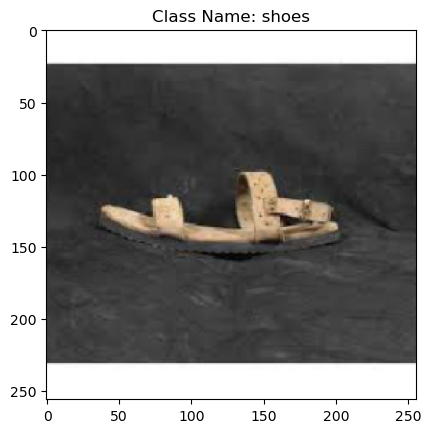

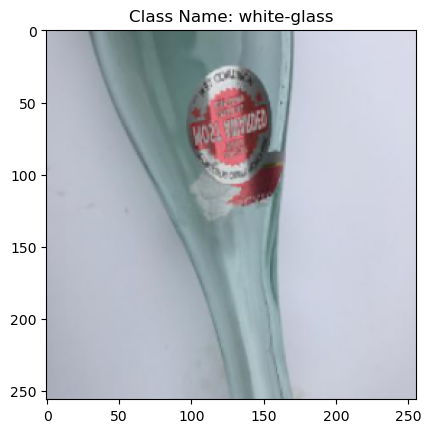

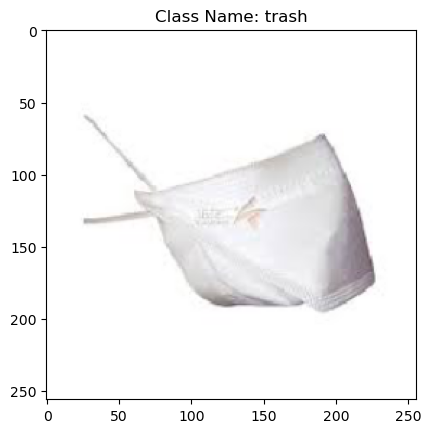

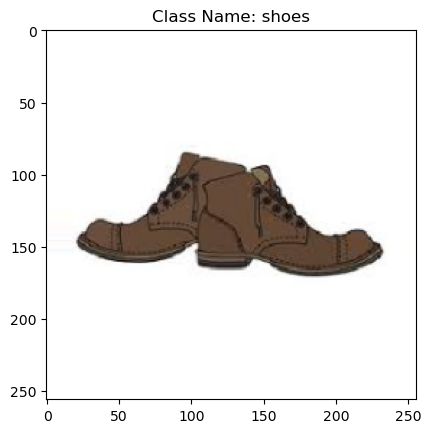

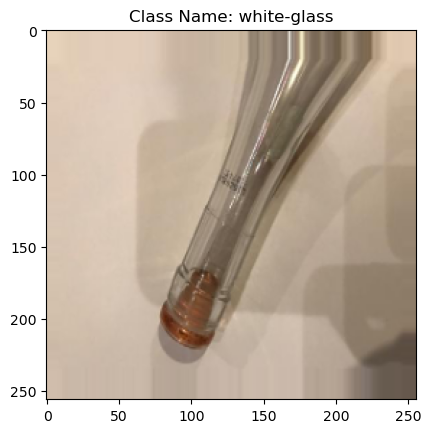

In [14]:
# Visualize the first few images in the batch with class names
for i in range(num_images_to_visualize):
    # Get the image and label
    image = batch_images[i]
    label_index = np.argmax(batch_labels[i])
    class_name = class_names[label_index]
    
    # Plot the image
    plt.imshow(image)
    plt.title(f"Class Name: {class_name}")
    plt.show()


***
## Definition of Test Statistics

In [ ]:
#test for signifcants different 
#the model's performance is not significantly different from random chance ??
def evaluate_model(model, validation_generator, alpha=0.05):
    # Assuming you have true labels for the validation set
    true_labels = validation_generator.classes  # Assuming you're using flow_from_directory

    # Make predictions on the validation set
    predicted_labels = model.predict(validation_generator)

    # Convert predicted probabilities to class labels
    predicted_labels = np.argmax(predicted_labels, axis=1)

    # Calculate the test statistic (accuracy)
    observed_accuracy = accuracy_score(true_labels, predicted_labels)

    # Perform a paired t-test
    t_statistic, p_value = ttest_rel(true_labels, predicted_labels)

    # Check if the p-value is less than alpha
    if p_value < alpha:
        print("Reject the null hypothesis. There is a significant difference.")
    else:
        print("Fail to reject the null hypothesis. No significant difference.")

    # Print additional information
    print(f"Observed Accuracy: {observed_accuracy:.4f}")
    print(f"T-Statistic: {t_statistic:.4f}")
    print(f"P-Value: {p_value:.4f}")

#example: evaluate_model(your_trained_model, your_validation_generator)

In [ ]:
import numpy as np
from scipy.stats import ttest_rel
from sklearn.metrics import accuracy_score

def compare_models(model_A, model_B, test_data, validation_generator, alpha=0.05):
    # Assuming you have true labels for the test set
    true_labels = validation_generator.classes  # Ground truth labels

    # Make predictions on the test set for both models
    predicted_labels_model_A = model_A.predict(test_data)
    predicted_labels_model_B = model_B.predict(test_data)

    # Convert predicted probabilities to class labels
    predicted_labels_model_A = np.argmax(predicted_labels_model_A, axis=1)
    predicted_labels_model_B = np.argmax(predicted_labels_model_B, axis=1)

    # Calculate the test statistic (accuracy)
    accuracy_model_A = accuracy_score(true_labels, predicted_labels_model_A)
    accuracy_model_B = accuracy_score(true_labels, predicted_labels_model_B)

    # Perform a paired t-test
    t_statistic, p_value = ttest_rel(accuracy_model_A, accuracy_model_B)

    # Check if the p-value is less than alpha
    if p_value < alpha:
        print("Reject the null hypothesis. There is a significant difference.")
    else:
        print("Fail to reject the null hypothesis. No significant difference.")

    # Print additional information
    print(f"Accuracy Model A: {accuracy_model_A:.4f}")
    print(f"Accuracy Model B: {accuracy_model_B:.4f}")
    print(f"T-Statistic: {t_statistic:.4f}")
    print(f"P-Value: {p_value:.4f}")

## Example usage:
compare_models(your_model_A, your_model_B, your_test_data, your_validation_generator)


***
## Implementing CNN - own build

In [15]:
# Define the CNN model
num_classes = len(train_generator.class_indices)

model_cnn1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256,256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Adjust 'num_classes' based on your task
])

# Compile the model
#model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the model with the legacy Adam optimizer
model_cnn1.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


# Display the model summary
model_cnn1.summary()

    # Define a callback to save the best model during training
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)
    # Define a callback to save the best model during training in the native Keras format
#checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)


# Train the model
history = model_cnn1.fit(
    train_generator,
    epochs=50,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[checkpoint]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

/Users/linuszarse/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


388/388 [==============================] - 301s 774ms/step - loss: 1.0114 - accuracy: 0.6592 - val_loss: 1.1530 - val_accuracy: 0.6187
Epoch 3/50
388/388 [==============================] - 291s 750ms/step - loss: 0.8573 - accuracy: 0.7182 - val_loss: 1.0420 - val_accuracy: 0.6719
Epoch 4/50
388/388 [==============================] - 288s 742ms/step - loss: 0.7535 - accuracy: 0.7552 - val_loss: 1.0731 - val_accuracy: 0.6606
Epoch 5/50
388/388 [==============================] - 282s 727ms/step - loss: 0.6829 - accuracy: 0.7748 - val_loss: 0.8934 - val_accuracy: 0.7190
Epoch 6/50
388/388 [==============================] - 288s 743ms/step - loss: 0.6226 - accuracy: 0.7973 - val_loss: 0.9316 - val_accuracy: 0.6977
Epoch 7/50
388/388 [==============================] - 293s 755ms/step - loss: 0.5722 - accuracy: 0.8138 - val_loss: 0.8653 - val_accuracy: 0.7265
Epoch 8/50
388/388 [==============================] - 292s 752ms/step - loss: 0.5225 - accuracy: 0.8271 - val_loss: 0.9021 - val_accura

In [16]:
#Assuming you have true labels for the validation set
true_labels = validation_generator.classes  # Assuming you're using flow_from_directory

# Make predictions on the validation set
predicted_labels = model_cnn1.predict(validation_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predicted_labels, axis=1)

# Calculate the test statistic (accuracy)
observed_accuracy = accuracy_score(true_labels, predicted_labels)

# Perform a paired t-test
t_statistic, p_value = ttest_rel(true_labels, predicted_labels)

# Choose a significance level (e.g., alpha = 0.05)
alpha = 0.05

# Check if the p-value is less than alpha
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference.")
else:
    print("Fail to reject the null hypothesis. No significant difference.")


97/97 [==============================] - 29s 291ms/step
Fail to reject the null hypothesis. No significant difference.


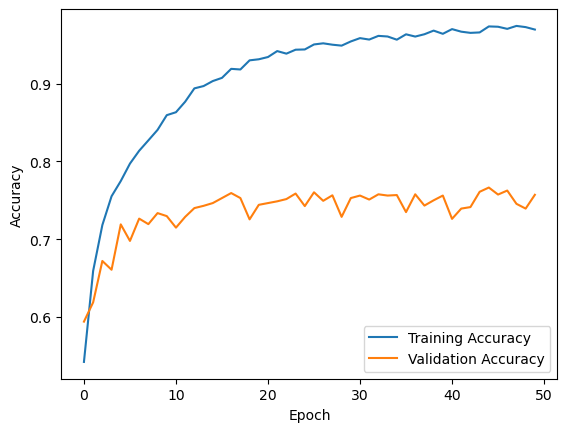

In [17]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


# Display the model summary
model.summary()

    # Define a callback to save the best model during training
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)
    # Define a callback to save the best model during training in the native Keras format
#checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)


# Train the model
history = model.fit(
    train_generator,
    epochs=50,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[checkpoint]
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                      

/Users/linuszarse/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


388/388 [==============================] - 422s 1s/step - loss: 1.7390 - accuracy: 0.5064 - val_loss: 1.7426 - val_accuracy: 0.4355
Epoch 2/50
388/388 [==============================] - 416s 1s/step - loss: 1.2622 - accuracy: 0.6010 - val_loss: 1.4393 - val_accuracy: 0.5723
Epoch 3/50
388/388 [==============================] - 411s 1s/step - loss: 1.0919 - accuracy: 0.6478 - val_loss: 1.2006 - val_accuracy: 0.6248
Epoch 4/50
388/388 [==============================] - 414s 1s/step - loss: 0.9909 - accuracy: 0.6818 - val_loss: 1.0308 - val_accuracy: 0.6542
Epoch 5/50
388/388 [==============================] - 420s 1s/step - loss: 0.9153 - accuracy: 0.7072 - val_loss: 1.2460 - val_accuracy: 0.5913
Epoch 6/50
388/388 [==============================] - 403s 1s/step - loss: 0.8575 - accuracy: 0.7237 - val_loss: 1.3743 - val_accuracy: 0.5597
Epoch 7/50
388/388 [==============================] - 441s 1s/step - loss: 0.8151 - accuracy: 0.7374 - val_loss: 1.0622 - val_accuracy: 0.6561
Epoch 8/50

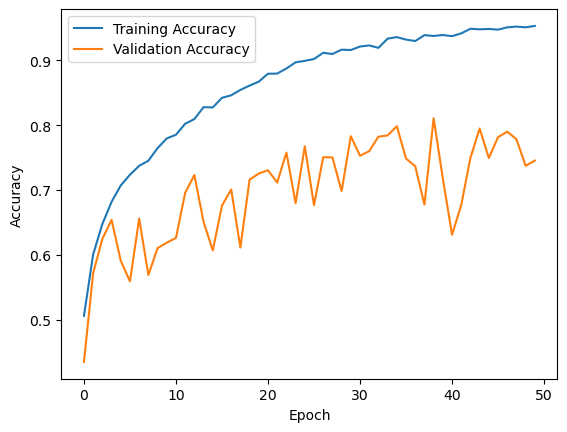

In [19]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

*** 
## Graphical Convolutional Network

In [20]:
# Get a batch of data and labels from the generator
batch_data, batch_labels = next(train_generator)

# Display the shape of the batch data and labels
print("Batch Data Shape:", batch_data.shape)
print("Batch Labels Shape:", batch_labels.shape)

Batch Data Shape: (32, 256, 256, 3)
Batch Labels Shape: (32, 12)


## With Hyperparameter Tuning:

In [21]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Add more convolutional layers
    for i in range(hp.Int('num_conv_layers', min_value=1, max_value=3, step=1)):
        model.add(Conv2D(hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
                         (3, 3),
                         activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    
    # Add more dense layers
    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=2, step=1)):
        model.add(Dense(hp.Int(f'units_{i}', min_value=128, max_value=512, step=128), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(num_classes, activation='softmax'))

    # Tune the learning rate
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_lr), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [22]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    num_initial_points=2,  # Number of randomly sampled hyperparameter combinations
    directory='bayesian_optimization',
    project_name='garbage_classification'
)

tuner.search(train_generator, epochs=10, validation_data=validation_generator)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from bayesian_optimization/garbage_classification/tuner0.json


In [23]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='hyperparameter_tuning',
    project_name='garbage_classification'
)

tuner.search(train_generator, epochs=10, validation_data=validation_generator)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Reloading Tuner from hyperparameter_tuning/garbage_classification/tuner0.json


<div class="alert alert-block alert-info">
<b>Training Metrics Explanation:</b>

- **loss:**
  - The training loss at the end of the epoch. It represents the average value of the loss function across all training samples.

- **accuracy:**
  - The training accuracy at the end of the epoch. It represents the proportion of correctly classified training samples.

- **val_loss:**
  - The validation loss at the end of the epoch. It represents the average value of the loss function across all validation samples.
  
  Categorical Crossentropy Loss Formula:
  
  
  Categorical Crossentropy Loss =$ - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{i,j} \cdot \log(\hat{y}_{i,j})$

  Where:
    - $N$ is the number of samples in the batch.
    - $C$ is the number of classes.
    - $y_{i,j}$ is 1 if the true class of sample \(i\) is \(j\), 0 otherwise.
    - $(\hat{y}_{i,j})$ is the predicted probability that sample \(i\) belongs to class \(j\).

- **val_accuracy:**
  - The validation accuracy at the end of the epoch. It represents the proportion of correctly classified validation samples.
</div>


## Visualize CNN 

In [24]:
#ann_viz(model, view=True, filename=”cconstruct_model”, title=”CNN — Model 1”)

In [25]:
#visualkeras.layered_view(model, legend=True)

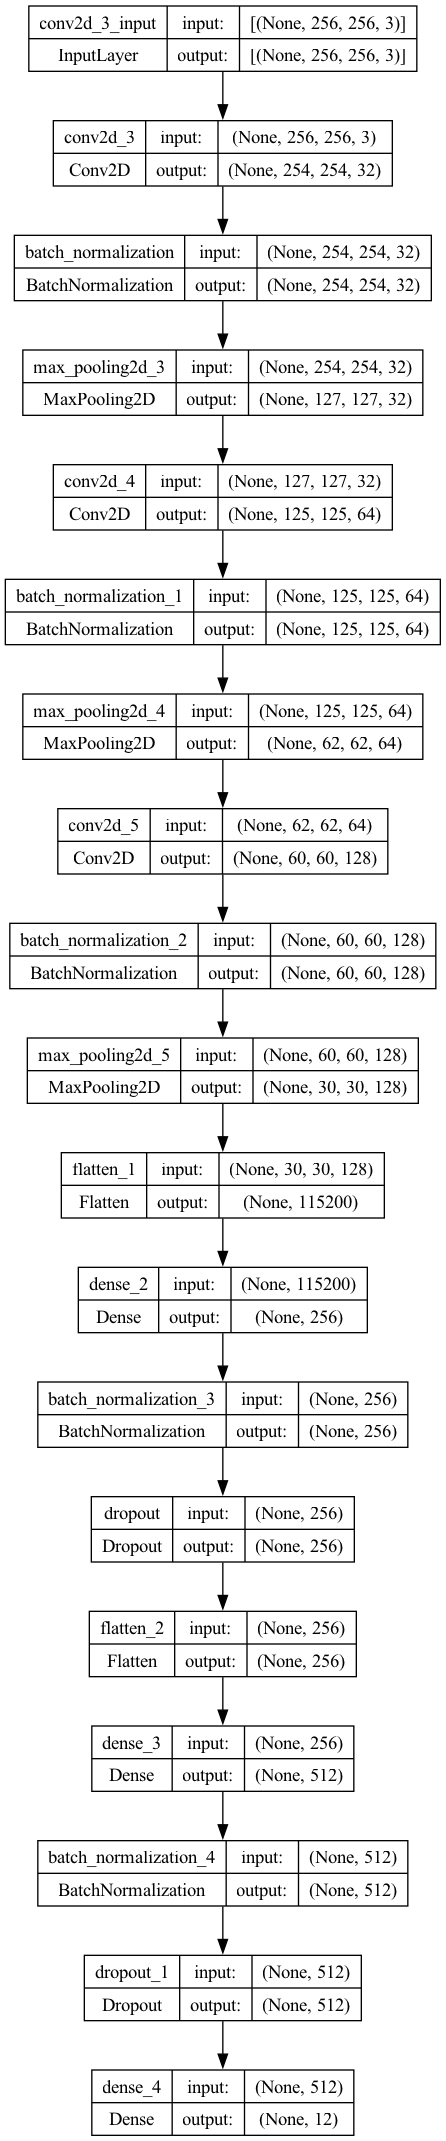

In [26]:
num_classes = len(train_generator.class_indices)
# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Pre-Trained Models

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Check if a GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU found. Please make sure you have a GPU and TensorFlow is configured to use it.")


# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add pre-trained layers
model_VGG16 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_VGG16.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_VGG16.summary()

# Define a callback to save the best model during training
checkpoint = ModelCheckpoint("best_model_resnet.h5", monitor='val_loss', save_best_only=True)

# Train the model
history = model_VGG16.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

No GPU found. Please make sure you have a GPU and TensorFlow is configured to use it.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               8388864   
                                                                 
 dense_10 (Dense)            (None, 12)                3084      
                                                                 
Total params: 23106636 (88.14 MB)
Trainable params: 8391948 (32.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/10
388/388 [==============================] - 1949s 5s/step - loss: 0.8144 - accuracy: 0.7754 - val_loss: 0.6285 - val_accuracy: 0.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add pre-trained layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Define a callback to save the best model during training
checkpoint = ModelCheckpoint("best_model_resnet.h5", monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[checkpoint]
)


## Hypothesis test of model comparition

In [ ]:
from scipy.stats import ttest_rel
from sklearn.metrics import accuracy_score

# Assuming you have true labels for the test set
true_labels = ...  # Ground truth labels

# Make predictions on the test set for both models
predicted_labels_model_A = model_A.predict(test_data)
predicted_labels_model_B = model_B.predict(test_data)

# Convert predicted probabilities to class labels
predicted_labels_model_A = np.argmax(predicted_labels_model_A, axis=1)
predicted_labels_model_B = np.argmax(predicted_labels_model_B, axis=1)

# Calculate the test statistic (accuracy)
accuracy_model_A = accuracy_score(true_labels, predicted_labels_model_A)
accuracy_model_B = accuracy_score(true_labels, predicted_labels_model_B)

# Perform a paired t-test
t_statistic, p_value = ttest_rel(accuracy_model_A, accuracy_model_B)

# Choose a significance level (e.g., alpha = 0.05)
alpha = 0.05

# Check if the p-value is less than alpha
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference.")
else:
    print("Fail to reject the null hypothesis. No significant difference.")


# Points to think about:
* generalisation of the model -> do not overfit
* Hypothesis testing 
* Evaluation Protocolls 
    * K-Fold Cross Validation
    * Nested Cross Validation 
* what is the best architecture for CNN???
* Hyperparameter TUNING
* Why Clustering does not make sense

* https://www.jeremyjordan.me/convnet-architectures/

***
## Hypothesis Definition 

In [ ]:
from scipy.stats import ttest_rel
# Assuming you have true labels for the validation set
true_labels = validation_generator.classes  # Assuming you're using flow_from_directory

# Make predictions on the validation set
predicted_labels = model.predict(validation_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predicted_labels, axis=1)

# Calculate the test statistic (accuracy)
observed_accuracy = accuracy_score(true_labels, predicted_labels)

# Perform a paired t-test
t_statistic, p_value = ttest_rel(true_labels, predicted_labels)

# Choose a significance level (e.g., alpha = 0.05)
alpha = 0.05

# Check if the p-value is less than alpha
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference.")
else:
    print("Fail to reject the null hypothesis. No significant difference.")